In [1]:
import numpy as np
import cv2
import csv
from glob import glob
import matplotlib.pyplot as plt
from collections import namedtuple
from copy import deepcopy
from tqdm import tqdm
import random
import os

In [2]:
src = 'train'
val_scenes = []
for f in os.scandir(src):
    if f.is_dir():
        cur_scene = os.path.split(f)[-1]
        print(f"Found scene {cur_scene} at {f.path}")
        val_scenes += [cur_scene]

Found scene sagrada_familia at train/sagrada_familia
Found scene sacre_coeur at train/sacre_coeur
Found scene buckingham_palace at train/buckingham_palace
Found scene taj_mahal at train/taj_mahal
Found scene st_peters_square at train/st_peters_square
Found scene brandenburg_gate at train/brandenburg_gate
Found scene notre_dame_front_facade at train/notre_dame_front_facade
Found scene piazza_san_marco at train/piazza_san_marco
Found scene pantheon_exterior at train/pantheon_exterior
Found scene temple_nara_japan at train/temple_nara_japan
Found scene st_pauls_cathedral at train/st_pauls_cathedral
Found scene lincoln_memorial_statue at train/lincoln_memorial_statue
Found scene colosseum_exterior at train/colosseum_exterior
Found scene british_museum at train/british_museum
Found scene trevi_fountain at train/trevi_fountain
Found scene grand_place_brussels at train/grand_place_brussels


Loaded 68 images.


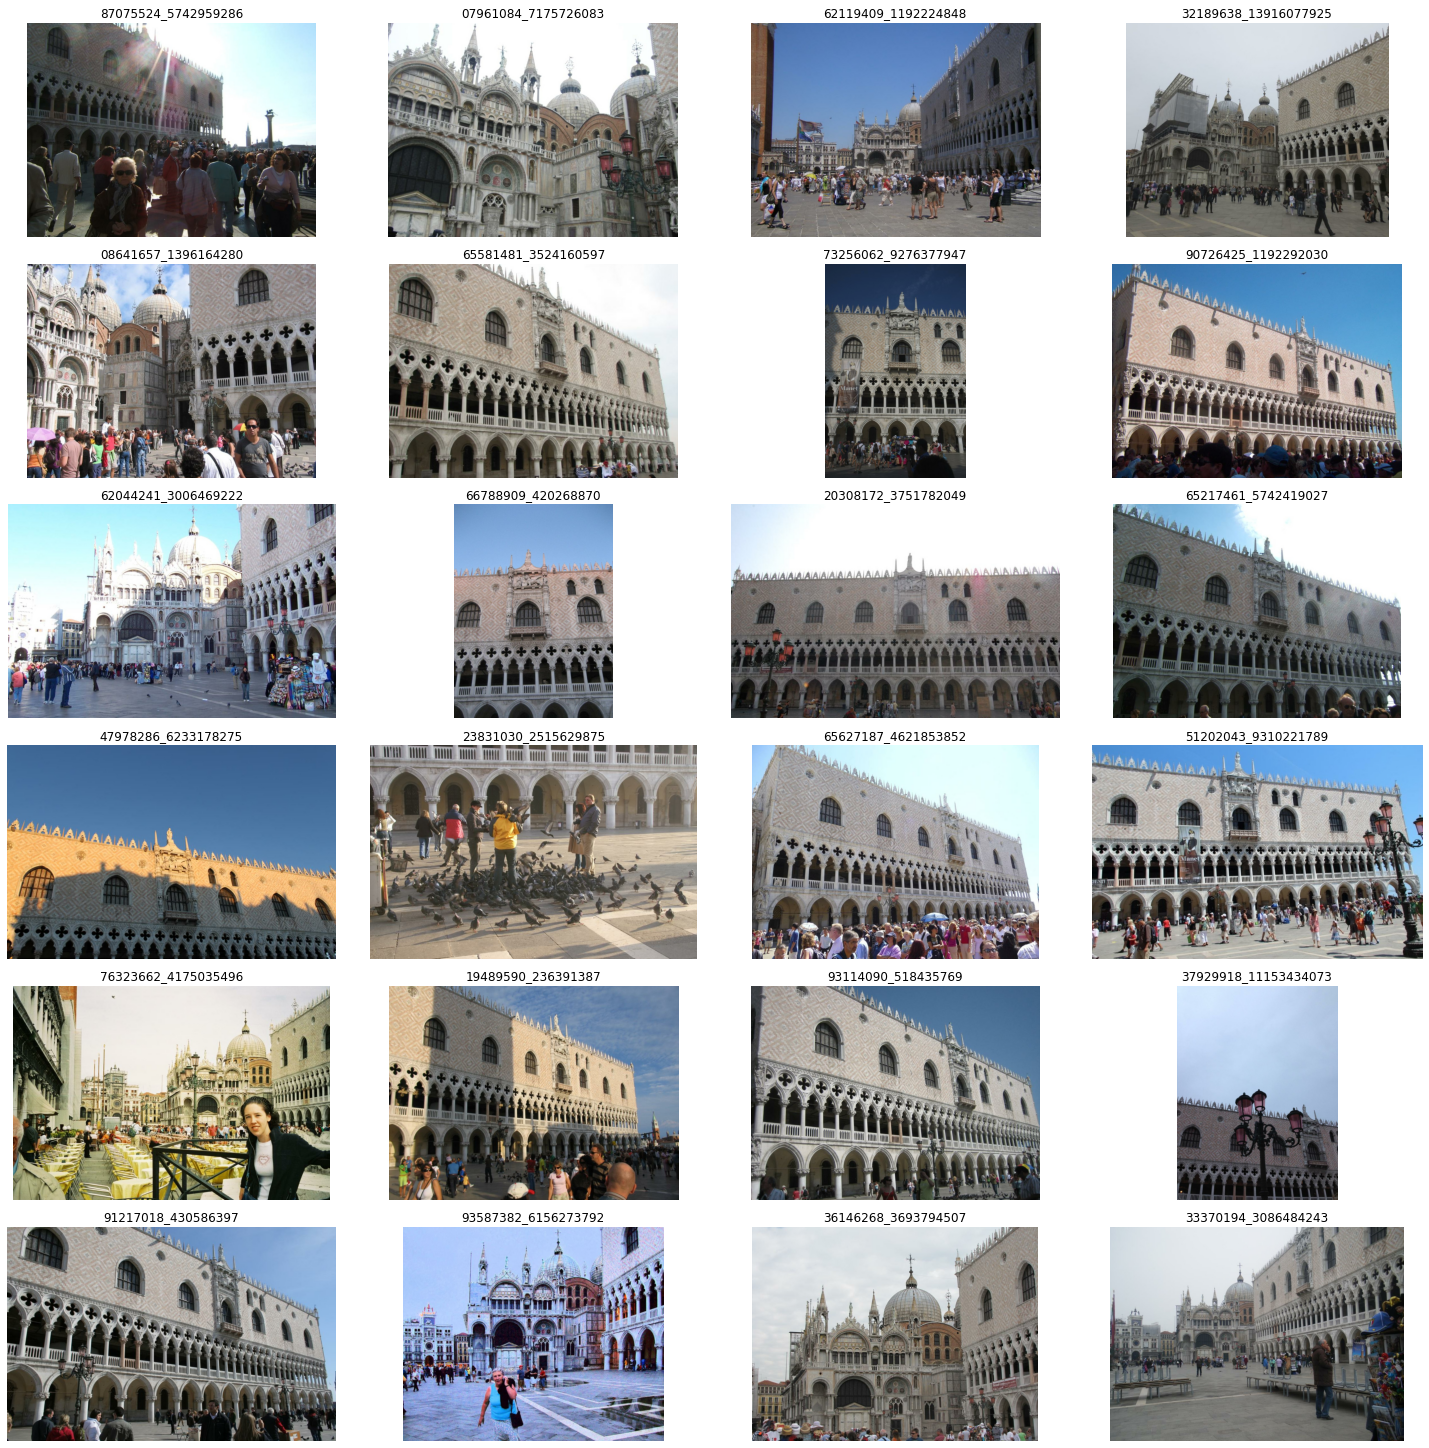

In [3]:
# Each scene in the validation set contains a list of images, poses, and pairs. Let's pick one and look at some images.

scene = 'piazza_san_marco'

images_dict = {}
for filename in glob(f'{src}/{scene}/images/*.jpg'):
    cur_id = os.path.basename(os.path.splitext(filename)[0])

    # OpenCV expects BGR, but the images are encoded in standard RGB, so you need to do color conversion if you use OpenCV for I/O.
    images_dict[cur_id] = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    
print(f'Loaded {len(images_dict)} images.')

num_rows = 6
num_cols = 4
f, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20), constrained_layout=True)
for i, key in enumerate(images_dict):
    if i >= num_rows * num_cols:
        break
    cur_ax = axes[i % num_rows, i // num_rows]
    cur_ax.imshow(images_dict[key])
    cur_ax.set_title(key)
    cur_ax.axis('off')

In [74]:
# A small epsilon.
eps = 1e-15

Gt = namedtuple('Gt', ['K', 'R', 'T'])
def ReadCovisibilityData(filename):
    covisibility_dict = {}
    with open(filename) as f:
        reader = csv.reader(f, delimiter=',')
        for i, row in enumerate(reader):
            # Skip header.
            if i == 0:
                continue
            covisibility_dict[row[0]] = float(row[1])

    return covisibility_dict

def ExtractSiftFeatures(image, detector, num_features):
    '''Compute SIFT features for a given image.'''
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    kp, desc = detector.detectAndCompute(gray, None)
    return kp[:num_features], desc[:num_features]

def ArrayFromCvKps(kps):
    '''Convenience function to convert OpenCV keypoints into a simple numpy array.'''
    
    return np.array([kp.pt for kp in kps])

def BuildCompositeImage(im1, im2, axis=1, margin=0, background=1):
    '''Convenience function to stack two images with different sizes.'''
    
    if background != 0 and background != 1:
        background = 1
    if axis != 0 and axis != 1:
        raise RuntimeError('Axis must be 0 (vertical) or 1 (horizontal')

    h1, w1, _ = im1.shape
    h2, w2, _ = im2.shape

    if axis == 1:
        composite = np.zeros((max(h1, h2), w1 + w2 + margin, 3), dtype=np.uint8) + 255 * background
        if h1 > h2:
            voff1, voff2 = 0, (h1 - h2) // 2
        else:
            voff1, voff2 = (h2 - h1) // 2, 0
        hoff1, hoff2 = 0, w1 + margin
    else:
        composite = np.zeros((h1 + h2 + margin, max(w1, w2), 3), dtype=np.uint8) + 255 * background
        if w1 > w2:
            hoff1, hoff2 = 0, (w1 - w2) // 2
        else:
            hoff1, hoff2 = (w2 - w1) // 2, 0
        voff1, voff2 = 0, h1 + margin
    composite[voff1:voff1 + h1, hoff1:hoff1 + w1, :] = im1
    composite[voff2:voff2 + h2, hoff2:hoff2 + w2, :] = im2

    return (composite, (voff1, voff2), (hoff1, hoff2))

def DrawMatches(im1, im2, kp1, kp2, matches, axis=1, margin=0, background=0, linewidth=2):
    '''Draw keypoints and matches.'''
    
    composite, v_offset, h_offset = BuildCompositeImage(im1, im2, axis, margin, background)

    # Draw all keypoints.
    for coord_a, coord_b in zip(kp1, kp2):
        composite = cv2.drawMarker(composite, (int(coord_a[0] + h_offset[0]), int(coord_a[1] + v_offset[0])), color=(255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=5, thickness=1)
        composite = cv2.drawMarker(composite, (int(coord_b[0] + h_offset[1]), int(coord_b[1] + v_offset[1])), color=(255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=5, thickness=1)
    
    # Draw matches, and highlight keypoints used in matches.
    for idx_a, idx_b in matches:
        composite = cv2.drawMarker(composite, (int(kp1[idx_a, 0] + h_offset[0]), int(kp1[idx_a, 1] + v_offset[0])), color=(0, 0, 255), markerType=cv2.MARKER_CROSS, markerSize=12, thickness=1)
        composite = cv2.drawMarker(composite, (int(kp2[idx_b, 0] + h_offset[1]), int(kp2[idx_b, 1] + v_offset[1])), color=(0, 0, 255), markerType=cv2.MARKER_CROSS, markerSize=12, thickness=1)
        composite = cv2.line(composite,
                             tuple([int(kp1[idx_a][0] + h_offset[0]),
                                   int(kp1[idx_a][1] + v_offset[0])]),
                             tuple([int(kp2[idx_b][0] + h_offset[1]),
                                   int(kp2[idx_b][1] + v_offset[1])]), color=(0, 0, 255), thickness=1)
    return composite


def LoadCalibration(filename):
    '''Load calibration data (ground truth) from the csv file.'''
    
    calib_dict = {}
    with open(filename, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        for i, row in enumerate(reader):
            # Skip header.
            if i == 0:
                continue

            camera_id = row[0]
            K = np.array([float(v) for v in row[1].split(' ')]).reshape([3, 3])
            R = np.array([float(v) for v in row[2].split(' ')]).reshape([3, 3])
            T = np.array([float(v) for v in row[3].split(' ')])
            calib_dict[camera_id] = Gt(K=K, R=R, T=T)
    
    return calib_dict

matches_after_ransac = np.array([match for match, is_inlier in zip(matches, inlier_mask) if is_inlier])

NameError: name 'inlier_mask' is not defined

In [ ]:
# Two images from the same scene may not always overlap.
# The dataset contains co-visibility estimates that you can use to find pairs with more or less overlap.
# We recommend using all pairs with a co-visibility estimate of 0.1 or larger.
# For more details, please see Section 3.2 of the paper: https://arxiv.org/abs/2003.01587.

covisibility_dict = ReadCovisibilityData(f'{src}/{scene}/pair_covisibility.csv')

# Let's look at easy pairs first, and difficult pairs later.
easy_subset = [k for k, v in covisibility_dict.items() if v >= 0.7]
difficult_subset = [k for k, v in covisibility_dict.items() if v >= 0.1 and v < 0.2]

for i, subset in enumerate([easy_subset, difficult_subset]):
    print(f'Pairs from an {"easy" if i == 0 else "difficult"} subset')
    
    for pair in subset[:4]:
        # A pair string is simply two concatenated image IDs, separated with a hyphen.
        image_id_1, image_id_2 = pair.split('-')

        f, axes = plt.subplots(1, 2, figsize=(15, 10), constrained_layout=True)
        axes[0].imshow(images_dict[image_id_1])
        axes[0].set_title(image_id_1)
        axes[1].imshow(images_dict[image_id_2])
        axes[1].set_title(image_id_2)
        for ax in axes:
            ax.axis('off')
        plt.show()

    print()
    print()

fig = plt.figure(figsize=(15, 10), constrained_layout=True)
plt.title('Covisibility histogram')
plt.hist(list(covisibility_dict.values()), bins=10, range=[0, 1])
plt.show()

Computed 5000 features.


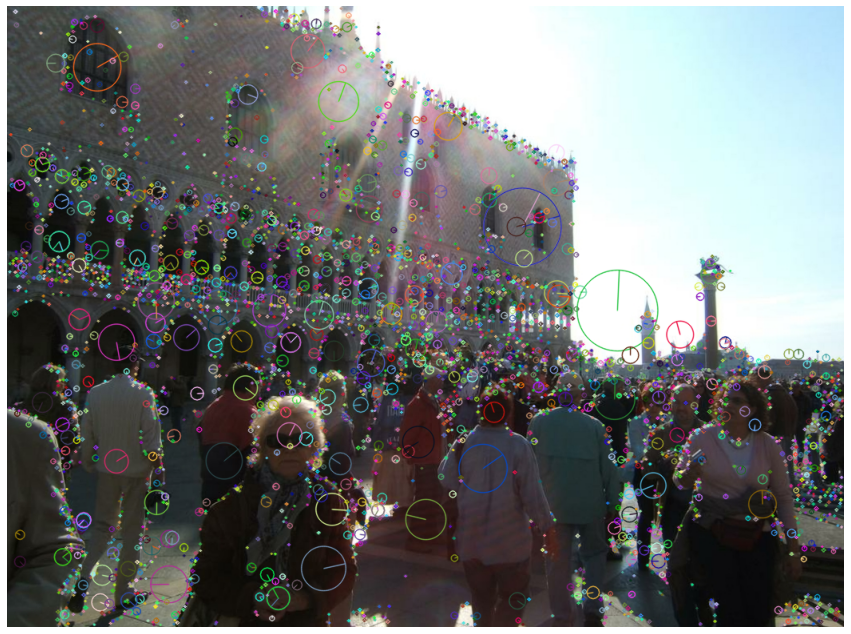

In [61]:
# This problem is typically (but not always!) solved with sparse features.
# Let's try using SIFT, a seminal work in computer vision (https://en.wikipedia.org/wiki/Scale-invariant_feature_transform).
# No longer the state of the art, but still pretty solid!

num_features = 5000

# You may want to lower the detection threshold, as small images may not be able to reach the budget otherwise.
# Note that you may actually get more than num_features features, as a feature for one point can have multiple orientations (this is rare).
sift_detector = cv2.SIFT_create(num_features, contrastThreshold=-10000, edgeThreshold=-10000)

keys = list(images_dict.keys())
keypoints, descriptors = ExtractSiftFeatures(images_dict[keys[0]], sift_detector, num_features)
print(f'Computed {len(keypoints)} features.')

# Each local feature contains a keypoint (xy, possibly scale, possibly orientation) and a description vector (128-dimensional for SIFT).
image_with_keypoints = cv2.drawKeypoints(images_dict[keys[0]], keypoints, outImage=None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
fig = plt.figure(figsize=(15, 15))
plt.imshow(image_with_keypoints)
plt.axis('off')
plt.show()

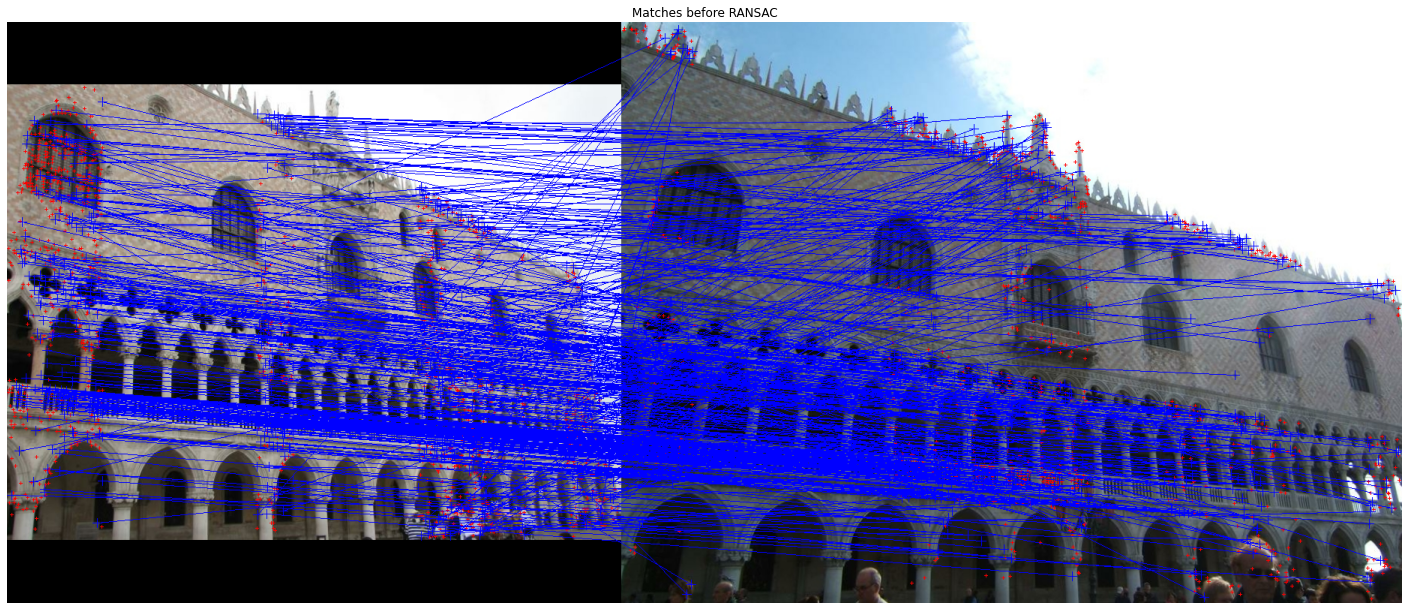

AttributeError: module 'cv2.cv2' has no attribute 'USAC_MAGSAC'

In [72]:
# We can find correspondences by brute-force-matching local features between two images. Let's do this for an easy pair.

pair = easy_subset[0]
image_id_1, image_id_2 = pair.split('-')
keypoints_1, descriptors_1 = ExtractSiftFeatures(images_dict[image_id_1], sift_detector, 2000)
keypoints_2, descriptors_2 = ExtractSiftFeatures(images_dict[image_id_2], sift_detector, 2000)

# For each descriptor on one image, find the closest descriptor on the other image.
# With crossCheck=True we keep only bidirectional matches (i.e., two features are nearest neighbours from A to B and also from B to A).
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Compute matches.
cv_matches = bf.match(descriptors_1, descriptors_2)

# Convert keypoints and matches to something more human-readable.
cur_kp_1 = ArrayFromCvKps(keypoints_1)
cur_kp_2 = ArrayFromCvKps(keypoints_2)
matches = np.array([[m.queryIdx, m.trainIdx] for m in cv_matches])

# Plot the brute-force matches.
im_matches = DrawMatches(images_dict[image_id_1], images_dict[image_id_2], cur_kp_1, cur_kp_2, matches)
fig = plt.figure(figsize=(25, 25))
plt.title('Matches before RANSAC')
plt.imshow(im_matches)
plt.axis('off')
plt.show()

# Notice that this includes many outliers. We can filter them with a state-of-the-art RANSAC algorithm. References:
# * https://docs.opencv.org/4.5.4/d9/d0c/group__calib3d.html#ga59b0d57f46f8677fb5904294a23d404a
# * https://opencv.org/evaluating-opencvs-new-ransacs

# OpenCV gives us the Fundamental matrix after RANSAC, and a mask over the input matches. The solution is clearly much cleaner, even though it may still contain outliers.
# This F is the prediction you'll submit to the contest.
F, inlier_mask = cv2.findFundamentalMat(cur_kp_1[matches[:, 0]], cur_kp_2[matches[:, 1]], cv2.USAC_MAGSAC, ransacReprojThreshold=0.25, confidence=0.99999, maxIters=10000)

matches_after_ransac = np.array([match for match, is_inlier in zip(matches, inlier_mask) if is_inlier])
im_inliers = DrawMatches(images_dict[image_id_1], images_dict[image_id_2], cur_kp_1, cur_kp_2, matches_after_ransac)
fig = plt.figure(figsize=(25, 25))
plt.title('Matches before RANSAC')
plt.imshow(im_inliers)
plt.axis('off')
plt.show()

In [75]:
F, inlier_mask = cv2.findFundamentalMat(cur_kp_1[matches[:, 0]], cur_kp_2[matches[:, 1]], cv2.USAC_MAGSAC, ransacReprojThreshold=0.25, confidence=0.99999, maxIters=10000)


# Is this any good? Let's load the ground truth.

calib_dict = LoadCalibration(f'{src}/{scene}/calibration.csv')
print(f'Loded ground truth data for {len(calib_dict)} images')
print()

# One important caveat: the scenes were reconstructed from unstructured image collections using Structure-from-Motion (http://colmap.github.io), and are not up to "real-world" scale (i.e. meters, or inches).
# We computed a scaling factor per scene to correct this. This is necessary to compute the metric correctly.

scaling_dict = {}
with open(f'{src}/scaling_factors.csv') as f:
    reader = csv.reader(f, delimiter=',')
    for i, row in enumerate(reader):
        # Skip header.
        if i == 0:
            continue
        scaling_dict[row[0]] = float(row[1])

print(f'Scaling factors: {scaling_dict}')
print()

# We can compute the errors now. First, let's decompose the Fundamental matrix we just estimated. TODO explain why we do this.
inlier_kp_1 = ArrayFromCvKps([kp for i, kp in enumerate(keypoints_1) if i in matches_after_ransac[:, 0]])
inlier_kp_2 = ArrayFromCvKps([kp for i, kp in enumerate(keypoints_2) if i in matches_after_ransac[:, 1]])
E, R, T = ComputeEssentialMatrix(F, calib_dict[image_id_1].K, calib_dict[image_id_2].K, inlier_kp_1, inlier_kp_2)
q = QuaternionFromMatrix(R)
T = T.flatten()

# Get the ground truth relative pose difference for this pair of images.
R1_gt, T1_gt = calib_dict[image_id_1].R, calib_dict[image_id_1].T.reshape((3, 1))
R2_gt, T2_gt = calib_dict[image_id_2].R, calib_dict[image_id_2].T.reshape((3, 1))
dR_gt = np.dot(R2_gt, R1_gt.T)
dT_gt = (T2_gt - np.dot(dR_gt, T1_gt)).flatten()
q_gt = QuaternionFromMatrix(dR_gt)
q_gt = q_gt / (np.linalg.norm(q_gt) + eps)

# Given ground truth and prediction, compute the error for the example above.
err_q, err_t = ComputeErrorForOneExample(q_gt, dT_gt, q, T, scaling_dict[scene])
print(f'Pair "{pair}, rotation_error={err_q:.02f} (deg), translation_error={err_t:.02f} (m)', flush=True)

AttributeError: module 'cv2.cv2' has no attribute 'USAC_MAGSAC'